## Problématique

#### Identifier si une image provenant d'un anime est officielle ou un fan art à l'aide d'une prédiction par catégorie. Les données proviennent des résultats du moteur de recherche duckduckgo.com et seront labelisées à l'aide des mots-clés de recherche.

In [3]:
# Installation de fastai
!pip install -Uqq fastai

### Téléchargement des images officielles et faites par des fans

In [ ]:
# Installation de duckduckgo_search pour faire les recherche d'images
!pip install -Uqq duckduckgo_search

In [68]:
from duckduckgo_search import ddg_images
from fastcore.all import *

# fonction qui permet de chercher des images
def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [69]:
# recherche d'une image avec les mots clés : "anime", "official" et "art"
urls = search_images('anime official art', max_images=1)
urls[0]

'http://images6.fanpop.com/image/photos/38500000/Official-Art-noragami-38533907-6398-4083.jpg'

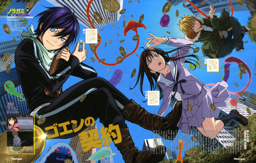

In [70]:
# On télécharge l'image et on l'affiche
from fastdownload import download_url
dest = 'anime-official.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

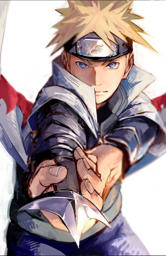

In [71]:
# On fait de même avec les mots-clés : "anime", "fan" et "art". On télécharge et on affiche l'image
download_url(search_images('anime fan art', max_images=2)[1], 'anime-fan-art.jpg', show_progress=False)
Image.open('anime-fan-art.jpg').to_thumb(256,256)

#### Les images ont l'air de correspondre à notre problématique, nous allons donc maintenant en télécharger une certaines quantité et les séparer dans deux dossiers différents appelés anime-official et anime-fan-art

In [72]:
path = Path('official-or-fan-art')

In [73]:
searches = 'anime official art','anime fan art'

from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(o))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

#### Maintenant qu'on possède nos données, on vérifie si elles ont bien été téléchargées, si non on les supprime

In [74]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

#### On prépare les données pour les entraîner

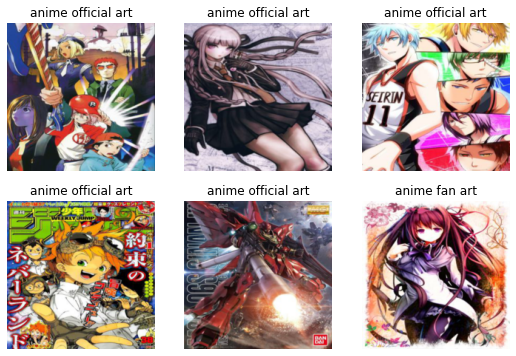

In [75]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(200, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

### On entraîne le modèle avec le réseau de neurones resnet18

In [76]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.031192,0.630267,0.281481,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.364787,0.298631,0.103704,00:06
1,0.242193,0.281388,0.096296,00:06
2,0.167591,0.223493,0.066667,00:06


### Utilisation du modèle

In [77]:
is_official,_,probs = learn.predict(PILImage.create('anime-official.jpg'))
print(f"This is a: {is_official}.")
print(f"Probability it's an anime official image: {probs[1]:.4f}")

This is a: anime official art.
Probability it's an anime official image: 0.9790


In [ ]:
learn.export()

In [16]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [17]:
learn_inf = load_learner(path/'export.pkl')

In [18]:
# retourne la categorie prédit, l'index de la categorie prédit et la probabilité de chaque categorie
learn_inf.predict(path/'anime-fan-art.jpg')

('anime fan art', TensorBase(0), TensorBase([0.8940, 0.1060]))

In [19]:
learn_inf.dls.vocab

['anime fan art', 'anime official art']

In [20]:
from fastai.vision.widgets import *

In [21]:
#hide_output

btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [22]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['anime-fan-art.jpg'])

In [23]:
img = PILImage.create(btn_upload.data[-1])

In [24]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [25]:
pred,pred_idx,probs = learn_inf.predict(img)

In [26]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: anime fan art; Probability: 0.8940')

In [27]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [28]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [29]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [30]:
#hide_output
VBox([widgets.Label('Select your image!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [31]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.1/213.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.7/593.7 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 1.9 MB/s eta 0:00:00
  Created wheel 

In [45]:
import gradio as gr

learn = load_learner('export.pkl')

labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

title = "Anime official image Classifier"
description = "<p style='text-align: center'>Identifier si une image provenant d'un anime est officielle ou un fan art. <br/> Peut par exemple aider à la diffusion de contenu en ligne (articles, posts sur les réseaux sociaux) avec des illustrations officielles.</p>"

demo = gr.Interface(fn=predict, title=title, description=description, examples = [path/'anime-official.jpg', path/'anime-fan-art.jpg'], inputs=gr.Image(shape=(512, 512)), outputs=gr.Label(num_top_classes=2))

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7871
Running on public URL: https://8a18b76cc3ee8120.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
